# Quantum_Diagonalization(Exp on Real Machines)

In [1]:
from qiskit import QuantumCircuit, transpile, Aer, execute, result
from qiskit.circuit import library as gate_lib

from numpy import pi
import numpy as np
import random
from scipy.optimize import minimize
from scipy import optimize
from matplotlib import pyplot as plt
import math

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
def get_initial_state_circ(N, type_):
    """

    @ Returns a N-qubit quantum circuit prepares the initial state from zero state

    - Arguments:
      - N(integer): number of qubits
      - type_(["neel", "domain_wall"]): type of initial state

    - Return
      - QuantumCircuit(of size N)

    """
    
    init_circ = QuantumCircuit(N)
    
    if (type_ == 'domain_wall'):
        for i in range(N//2, N):
            init_circ.x(i)
    elif (type_ == 'neel'):
        for i in range(N):
            if (i%2 == 1):
                init_circ.x(i)
                
    return init_circ

In [3]:
def get_N_circ(alpha, beta, gamma):
    """
    
    @ Returns N(alpha, beta, gamma) in the paper
    
    - Arguments:
      - alpha(float): alpha in radians
      - beta(float): beta in radians
      - gamma(float): gamma in radians
      
    - Return:
      - QuantumCircuit(of size 2)
    
    """
    
    theta = pi/2 - 2*gamma
    phi = 2*alpha - pi/2
    lambda_ = pi/2 - 2*beta
    
    N_circ = QuantumCircuit(2)
    N_circ.rz(-pi/2, 1)
    N_circ.cx(1, 0)
    N_circ.rz(theta, 0)
    N_circ.ry(phi, 1)
    N_circ.cx(0, 1)
    N_circ.ry(lambda_, 1)
    N_circ.cx(1, 0)
    N_circ.rz(pi/2, 0)
    
    return N_circ

In [4]:
def get_propagator_circ_nn(N, U, h, type_, delta_t, t):
    """
    
    @ Returns a N-qubit quantum circuit represents the propagator of 1D nearest neighborhood model
    
    - Arguments:
      - N(integer): number of qubits
      - U(float):
      - h(float):
      - type_(["XX", "XX_disordered", "XXZ", "XXZ_linear_potential"]): type of hamiltonian
      - delta_t(float): the propagation time of one block of unitary matrix
      - t(float): the total propagation time of returned quantum circuit (recommended to be integer times of delta_t)
      
    - Return
      - QuantumCircuit(of size n)
    
    """
    
    def delta_t_propagator():
        delta_t_circ = QuantumCircuit(N)
        
        h_list = []    
        if (type_ == "XX_disordered"):
            for _ in range(N):
                h_list.append(random.random()*2*h - h)
                
        elif (type_ == "XXZ_linear_potential"):
            for i in range(N):
                h_list.append(h*(N-i))
        
        # Add the first Aj's in the Eq (18)
        if (h_list): #If the list is not empty
            for i in range(N):
                delta_t_circ.rz(h_list[i] * delta_t, i)
        
        # Add the Bj's in the Eq (18)
        for i in range(N//2):
            delta_t_circ.compose(get_N_circ(delta_t/2, delta_t/2, -U*delta_t/2), 
                         [2*i, 2*i+1], inplace=True)
        
        for i in range((N-1)//2):
            delta_t_circ.compose(get_N_circ(delta_t, delta_t, -U*delta_t), 
                         [2*i+1, 2*i+2], inplace=True)
        
        # Add the Bj's in the Eq (18)
        for i in range(N//2):
            delta_t_circ.compose(get_N_circ(delta_t/2, delta_t/2, -U*delta_t/2), 
                         [2*i, 2*i+1], inplace=True)
            
        # Add the last Aj's in the Eq (18)
        if (h_list): #If the list is not empty
            for i in range(N):
                delta_t_circ.rz(h_list[i] * delta_t, i)
        
        return delta_t_circ
    
    circ = QuantumCircuit(N)
    
    for _ in range(int(t/delta_t)):
        circ.compose(delta_t_propagator(), range(N), inplace=True)
    
    return circ

In [8]:
def simulate(N, backend, initial_state_circ, propagator_circ, shots):
    """
    
    @ Run the given circuit and returns the result
    
    - Arguments:
      - N(integer): number of particles
      - backend: backend for the execution
      - initial_state_circ(QuantumCircuit of size N): initial state preparation circuit from zero state
      - propagator_circ(QuantumCircuit of size N): propagator circuit
    
    - Return
      - Counts: qiskit.result.Counts instance of the execution
      
    """
    
    circ = QuantumCircuit(N, N)
    
    circ.compose(initial_state_circ, range(N), inplace=True)
    circ.compose(propagator_circ, range(N), inplace=True)
    circ.measure(range(N), range(N))
    
    res = execute(circ, backend=backend, shots=shots).result().get_counts()
    simulate.counter += 1
    clear_output(wait=True)
    print(f"Run#{simulate.counter}")
    
    return res

simulate.counter = 0

In [9]:
def find_vff_optimized_circuit(N, U):
    """
    
    @ Return the optimized circuit
    
    - Arguments:
      - N(integer): number of particles
      - U(QuantumCircuit of size N): circuit U to diagonalize
    
    - Return
      - QuantumCircuit(of size N): diagonalized quantum circuit
      - float: the lowest lhst cost function
      - sequence(of length len_thetas): sequence of thetas (circuit parameter)
      - sequence(of length len_gammas): sequence of gammas (circuit parameter)
    
    """
    
    def deriv_theta(ind, thetas, gammas):
        res = 0.5 * (get_lhst(get_V(thetas, gammas, pm_W=1, index_W=ind, fb_W='f')) 
                     - get_lhst(get_V(thetas, gammas, pm_W=-1, index_W=ind, fb_W='f'))
                     + get_lhst(get_V(thetas, gammas, pm_W=1, index_W=ind, fb_W='b'))
                     - get_lhst(get_V(thetas, gammas, pm_W=-1, index_W=ind, fb_W='b')))
    
        return res

    def deriv_gamma(ind, thetas, gammas):
        res = 0.5 * (get_lhst(get_V(thetas, gammas, pm_D=1, index_D=ind)) 
                 - get_lhst(get_V(thetas, gammas, pm_D=-1, index_D=ind)))

        return res
    
    # D (refer to implementation part of the paper)
    # pm=1 means +, pm=-1 means -
    def get_D(gammas_, pm=0, index=0):
        gammas_copy = gammas_.copy()
        
        if len(gammas_copy) != len_gammas:
            print("get_D: Error on length of gammas")
            return
        
        if pm == 1:
            gammas_copy[index] += pi/2
        elif pm == -1:
            gammas_copy[index] -= pi/2
        
        D_circ = QuantumCircuit(N)
        i = 0
        for j in range(N):
            D_circ.rz(gammas_copy[i], j)
            i += 1
            
        for j in range(N):
            for k in range(j+1, N):
                D_circ.rzz(gammas_copy[i], j, k)
                i += 1
                      
        return D_circ
    
    # W (refer to implementation part of the paper)
    # pm=1 means +, pm=-1 means -
    def get_W(thetas_, pm=0, index=0):    
        thetas_copy = thetas_.copy()
        
        if (len(thetas_copy) != len_thetas):
            print("get_W: Error on length of thetas")
            return
        
        if pm == 1:
            thetas_copy[index] += pi/2
        elif pm == -1:
            thetas_copy[index] -= pi/2
        
        W_circ = QuantumCircuit(N)
        i = 0
        for _ in range(layer_number_of_W):
            for k in range(N):
                W_circ.rx(thetas_copy[i], k)
                i += 1
                W_circ.ry(thetas_copy[i], k)
                i += 1
                W_circ.rz(thetas_copy[i], k)
                i += 1
            for k in range(N//2):
                W_circ.cx(2*k, 2*k+1)
            for k in range((N-1)//2):
                W_circ.cx(2*k+1, (2*k+2))
        for k in range(N):
            W_circ.rx(thetas_copy[i], k)
            i += 1
            W_circ.ry(thetas_copy[i], k)
            i += 1
            W_circ.rz(thetas_copy[i], k)
            i += 1
            
        return W_circ
                
    
    # V = W(thetas)D(gammas)W_dagger(thetas)
    # fb_W means front or back of W. 'f' means front and 'b' menas back
    def get_V(thetas, gammas, pm_W=0, index_W=0, fb_W='', pm_D=0, index_D=0):
        V_circ = QuantumCircuit(N)
        if fb_W == 'f':
            V_circ.compose(get_W(thetas, pm=pm_W, index=index_W), range(N), inplace=True)
        else:
            V_circ.compose(get_W(thetas), range(N), inplace=True)
        V_circ.barrier()
        V_circ.compose(get_D(gammas, pm=pm_D, index=index_D), range(N), inplace=True)
        V_circ.barrier()
        if fb_W == 'b':
            V_circ.compose(get_W(thetas, pm=pm_W, index=index_W).inverse(), range(N), inplace=True)
        else:
            V_circ.compose(get_W(thetas).inverse(), range(N), inplace=True)
        
        #display(V_circ.draw('mpl'))
        
        return V_circ
    
    # Conjugate(Not adjoint) of a circuit
    def circ_conjugate(V):
        basis_gates = ['rx', 'ry', 'rz', 'p', 'cx']
        decomposed_V = transpile(V, basis_gates=basis_gates)
        
        for gate_tuple in decomposed_V.data:
            if (isinstance(gate_tuple[0], gate_lib.RXGate) 
                or isinstance(gate_tuple[0], gate_lib.RZGate) 
                or isinstance(gate_tuple[0], gate_lib.PhaseGate)):
                gate_tuple[0].params[0] *= -1
        
        return decomposed_V
        
    # C_LHST circuit generation (measurement included)
    def get_lhst_circ(V):
        lhst_circ = QuantumCircuit(2*N, 2*N)
        for i in range(N):
            lhst_circ.h(i)
            lhst_circ.cx(i, N+i)
        lhst_circ.compose(U, range(N), inplace=True)
        lhst_circ.compose(circ_conjugate(V), range(N, 2*N), inplace=True)
        for i in range(N):
            lhst_circ.cx(i, N+i)
            lhst_circ.h(i)
        lhst_circ.measure(range(2*N), range(2*N))
        
        return lhst_circ
    
    def get_lhst(V):        
        shots = 8192
        exe_result = execute(get_lhst_circ(V), backend=backend, shots=shots).result()
        
        res = 1
        for i in range(N):
            try:
                count_00 = result.marginal_counts(exe_result, indices=[i, i+N]).get_counts()['00']
            except:
                count_00 = 0
            fidelity = count_00/shots
            res -= fidelity/N
            
        return res
    
    layer_number_of_W = 2
    len_thetas = (layer_number_of_W + 1) * (3 * N)
    len_gammas = N*(N+1)//2
    
    backend = Aer.get_backend('qasm_simulator')
    
    x = list(0 for _ in range(len_thetas+len_gammas))
    thetas = list(i for i in x[0:len_thetas])
    gammas = list(i for i in x[len_thetas:])
    
    shots=8192
    
    thres = 1e-4
    eta_0 = 1.1
    kappa = 0.5
    delta = 15
    
    best_thetas = []
    best_gammas = []
    best_lhst = 1

    i = 0
    while(True):
        iter_n = int(input("Iter?: "))
        
        if (iter_n == 0):
            break
            
        for _ in range(iter_n):
            i += 1
            clear_output(wait=True)
            eta = eta_0 / math.pow(1+(i/delta),kappa)

            print(f"Iteration {i}")
            lhst = get_lhst(get_V(thetas, gammas))
            print(f"LHST: {lhst}")

            #display(get_lhst_circ(get_V(thetas,gammas)).draw('mpl'))
            if lhst < best_lhst:
                best_lhst = lhst
                best_thetas = thetas.copy()
                best_gammas = gammas.copy()

            dthetas = []
            dgammas = []
            for j in range(len_thetas):
                dthetas.append(deriv_theta(j, thetas, gammas))
                thetas[j] -= eta * dthetas[j]
            for k in range(len_gammas):
                dgammas.append(deriv_gamma(k, thetas, gammas))
                gammas[k] -= eta * dgammas[k]

            #for j in range(len_thetas):
            #    thetas[j] -= eta * dthetas[j]
            #for k in range(len_gammas):
            #    gammas[k] -= eta * dgammas[k]
    
    return get_V(best_thetas, best_gammas), best_lhst, best_thetas, best_gammas

Iteration 60
LHST: 0.0
Iter?: 0
0.0
[-0.002642338316280805, 0.004519726300248482, -0.011994769098570847, -0.016332172564502156, 0.0008129919670157642, -0.01372603654106138, 0.3011797693650672, 1.5745513365713664, -0.007029157111182349, 0.034159643750724666, 0.005997947825821538, 0.004545046524032675, 0.0013691758391911118, -0.006664201878892178, -0.017583729209149985, -0.01667147516889276, -0.0042713895457484885, 0.0039057735806965928]
[1.9943003509179662, -1.9906463086749153, -0.0031022556129043978]


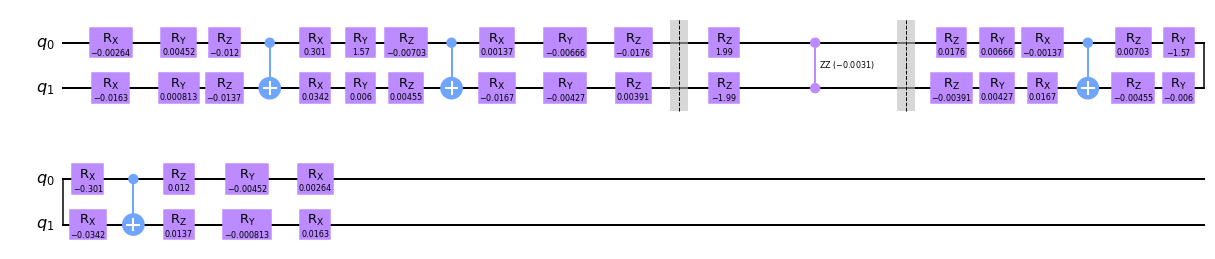

In [26]:
backend = Aer.get_backend('qasm_simulator')

N = 2
U = 0
h = 0
type_ = 'XX'
delta_t = 1
t = 10
shots = 100000

res = find_vff_optimized_circuit(2, get_propagator_circ_nn(N, U, h, type_, delta_t, delta_t))

print(res[1])
print(res[2])
print(res[3])
res[0].draw('mpl')

In [10]:
def get_vff_optimized_circuit_from_parameters(N, thetas, gammas):
    
    # ANSTAZ 모양 수정 시 이 부분도 수정하기!
    layer_number_of_W = 2
    len_thetas = (layer_number_of_W + 1) * (3 * N)
    len_gammas = N*(N+1)//2
    
# D (refer to implementation part of the paper)
    # pm=1 means +, pm=-1 means -
    def get_D(gammas_, pm=0, index=0):
        gammas_copy = gammas_.copy()
        
        if len(gammas_copy) != len_gammas:
            print("get_D: Error on length of gammas")
            return
        
        if pm == 1:
            gammas_copy[index] += pi/2
        elif pm == -1:
            gammas_copy[index] -= pi/2
        
        D_circ = QuantumCircuit(N)
        i = 0
        for j in range(N):
            D_circ.rz(gammas_copy[i], j)
            i += 1
            
        for j in range(N):
            for k in range(j+1, N):
                D_circ.rzz(gammas_copy[i], j, k)
                i += 1
                      
        return D_circ
    
    # W (refer to implementation part of the paper)
    # pm=1 means +, pm=-1 means -
    def get_W(thetas_, pm=0, index=0):    
        thetas_copy = thetas_.copy()
        
        if (len(thetas_copy) != len_thetas):
            print("get_W: Error on length of thetas")
            return
        
        if pm == 1:
            thetas_copy[index] += pi/2
        elif pm == -1:
            thetas_copy[index] -= pi/2
        
        W_circ = QuantumCircuit(N)
        i = 0
        for _ in range(layer_number_of_W):
            for k in range(N):
                W_circ.rx(thetas_copy[i], k)
                i += 1
                W_circ.ry(thetas_copy[i], k)
                i += 1
                W_circ.rz(thetas_copy[i], k)
                i += 1
            for k in range(N//2):
                W_circ.cx(2*k, 2*k+1)
            for k in range((N-1)//2):
                W_circ.cx(2*k+1, (2*k+2))
        for k in range(N):
            W_circ.rx(thetas_copy[i], k)
            i += 1
            W_circ.ry(thetas_copy[i], k)
            i += 1
            W_circ.rz(thetas_copy[i], k)
            i += 1
            
        return W_circ
                
    
    # V = W(thetas)D(gammas)W_dagger(thetas)
    # fb_W means front or back of W. 'f' means front and 'b' menas back
    def get_V(thetas, gammas):
        V_circ = QuantumCircuit(N)
        V_circ.compose(get_W(thetas), range(N), inplace=True)
        V_circ.barrier()
        V_circ.compose(get_D(gammas), range(N), inplace=True)
        V_circ.barrier()
        V_circ.compose(get_W(thetas).inverse(), range(N), inplace=True)
        
        #display(V_circ.draw('mpl'))
        
        return V_circ
    
    return get_V(thetas, gammas)

Run#60


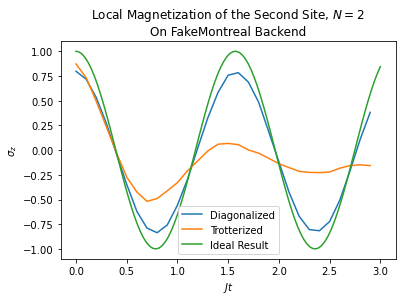

In [12]:
#from qiskit_ionq import IonQProvider 
#provider = IonQProvider(token='QJzGHXWGj8dOXnmi1S0ppfi5JW1DMr4J') 
#backend = provider.get_backend('ionq_qpu')

from qiskit.test.mock import FakeMontreal
backend = FakeMontreal()

#backend = Aer.get_backend('qasm_simulator')

simulate.counter=0

N = 2
U = 0
h = 0
type_ = 'XX'
delta_t = 0.1
t = 3.0
shots = 8096

num = 1

data = []
thetas = [-0.002642338316280805, 0.004519726300248482, -0.011994769098570847, -0.016332172564502156, 0.0008129919670157642, -0.01372603654106138, 0.3011797693650672, 1.5745513365713664, -0.007029157111182349, 0.034159643750724666, 0.005997947825821538, 0.004545046524032675, 0.0013691758391911118, -0.006664201878892178, -0.017583729209149985, -0.01667147516889276, -0.0042713895457484885, 0.0039057735806965928]
gammas_0 = [1.9943003509179662, -1.9906463086749153, -0.0031022556129043978]

for step in range(0, int(t/delta_t)):
    gammas = list(gamma_0 * step / 10 for gamma_0 in gammas_0) 
    counts = simulate(N, backend, get_initial_state_circ(N, 'domain_wall'),
                      get_vff_optimized_circuit_from_parameters(N, thetas, gammas),
                      shots)
    try:
        data.append(result.marginal_counts(counts, [num])['1']/shots * 2 - 1)
    except:
        data.append(0)

fig = plt.figure()
plt.plot(np.arange(0, t, delta_t), data, label='Diagonalized')  

data = []
for step in range(0, int(t/delta_t)):
    counts = simulate(N, backend, get_initial_state_circ(N, 'domain_wall'), 
                      get_propagator_circ_nn(N, U, h, type_, delta_t, step*delta_t), shots)
    try:
        data.append(result.marginal_counts(counts, [num])['1']/shots * 2 -1)
    except:
        data.append(0)
    
plt.plot(np.arange(0, t, delta_t), data, label='Trotterized')

classically_simulated = [1.0, 0.992662800847679, 0.9707588723735178, 0.934609641548382, 0.8847455765838065, 0.8218984026301698, 0.7469903641503894, 0.6611206915373363, 0.565549470569224, 0.46167915140899946, 0.3510339684920501, 0.23523757330298906, 0.11598920826706272, -0.004961228610014301, -0.12583886244238796, -0.2448698866850788, -0.3603075926777407, -0.47045800154326206, -0.5737047223085318, -0.6685326714693924, -0.7535503059294447, -0.827510043057703, -0.8893265682130418, -0.9380927610835209, -0.9730930071311599, -0.9938136988046938, -0.9999507724213582, -0.9914141701184775, -0.9683291613984114, -0.9310345048739853, -0.8800774771896731, -0.8162058420661349, -0.740356877317543, -0.6536436208636122, -0.5573385375678399, -0.45285484658127084, -0.3417257832017809, -0.22558209956862085, -0.10612813435599489, 0.014883197371500734, 0.13567612713271882, 0.2544780913639613, 0.3695457427227234, 0.4791905326609872, 0.5818034898591711, 0.67587883091213, 0.7600360567946085, 0.8330402108537933, 0.893820001055127, 0.9414835205483213, 0.9753313358637336, 0.9948667506776826, 0.9998030945321421, 0.9900679295512238, 0.965804113423418, 0.9273677030509754, 0.8753227296291012, 0.8104329218275439, 0.7336504985318941, 0.6461021956043881, 0.5490727317130789, 0.44398595585839434, 0.33238395324577713, 0.21590441611315908, 0.09625661158276555, -0.024803700805447526, -0.14550003380861354, -0.26406124136233305, -0.37874750908348326, -0.4878758849994502, -0.5898449758557074, -0.683158446598265, -0.7664469781902592, -0.838488361544901, -0.8982254327084257, -0.9447815861050272, -0.9774736381962318, -0.9958218527882577, -0.9995569808720023, -0.9886242116902447, -0.9631839770525326, -0.9236095970949021, -0.8704818020315106, -0.8045802102881667, -0.7268718880710214, -0.6384971582518749, -0.5407528668161586, -0.4350733524284042, -0.32300939837537923, -0.20620547575445075, -0.08637561184970438, 0.03472176218713191, 0.15530961525579495, 0.27361839316965436, 0.38791198579866537, 0.49651320344092426, 0.5978283885723743, 0.6903708018120911, 0.772782438928123, 0.8438539587324924]
plt.plot(np.linspace(0, 3, num=100), classically_simulated, label='Ideal Result')

plt.title('Local Magnetization of the Second Site, $N=2$\nOn FakeMontreal Backend')
plt.ylabel('$\sigma_{z}$')
plt.xlabel('$Jt$')

plt.legend()
plt.show()